## Wine quality

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. 

Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks. The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). 

Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to test feature selection methods.

### Load the dataset

In [61]:
# Load the libraries
import pandas as pd
import numpy as np
import imblearn
from matplotlib import pyplot
from pathlib import Path
from pandas.plotting import scatter_matrix
from collections import Counter

from sklearn.model_selection import train_test_split, KFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
filepath_red = Path("../data/winequality-red.csv")
filepath_white = Path("../data/winequality-white.csv")
assert all([filepath_red.is_file(), filepath_white.is_file()])
dataset_red = pd.read_csv(filepath_red, sep=";")
dataset_white = pd.read_csv(filepath_white, sep=";")

Initial Ideas

- Create one master dataset with dummy variable red or white?
- use white dataset for multi-classification problem as first pass with imbalanced classes



#### Data peek

In [4]:
dataset_white.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2404,9.8,0.16,0.46,1.8,0.046,23.0,130.0,0.99587,3.04,0.67,9.60,5
478,7.1,0.55,0.13,1.7,0.073,21.0,165.0,0.99400,2.97,0.58,9.20,6
1898,7.2,0.31,0.41,8.6,0.053,15.0,89.0,0.99760,3.29,0.64,9.90,6
4862,5.9,0.22,0.30,1.3,0.052,42.0,86.0,0.99069,3.31,0.47,11.55,6
722,6.9,0.31,0.34,1.6,0.032,23.0,128.0,0.99170,3.37,0.47,11.70,6


In [5]:
dataset_red.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
376,11.5,0.45,0.50,3.0,0.078,19.0,47.0,1.00030,3.26,1.11,11.0,6
1080,10.3,0.27,0.56,1.4,0.047,3.0,8.0,0.99471,3.16,0.51,11.8,6
880,9.2,0.56,0.18,1.6,0.078,10.0,21.0,0.99576,3.15,0.49,9.9,5
262,8.0,0.52,0.03,1.7,0.070,10.0,35.0,0.99575,3.34,0.57,10.0,5
1483,8.1,0.33,0.44,1.5,0.042,6.0,12.0,0.99542,3.35,0.61,10.7,5


### Data Summary

- one integer feature
- no null values
- same features in both datasets
- features might require scaling
- several outliers per input features , exception alcohol and density as expected
- output class (quality) is imbalanced, CART or ensemble algorithms might perform better; also consider SMOTE method o address this. 
- output is positively correlated with alcohol
- density and residual sugar positively correlated
- alcohol and density negatively correlated 


##### Data Shape

In [6]:
dataset_red.shape

(1599, 12)

In [7]:
dataset_white.shape

(4898, 12)

#### Data types


In [8]:
dataset_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [9]:
dataset_white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
fixed acidity           4898 non-null float64
volatile acidity        4898 non-null float64
citric acid             4898 non-null float64
residual sugar          4898 non-null float64
chlorides               4898 non-null float64
free sulfur dioxide     4898 non-null float64
total sulfur dioxide    4898 non-null float64
density                 4898 non-null float64
pH                      4898 non-null float64
sulphates               4898 non-null float64
alcohol                 4898 non-null float64
quality                 4898 non-null int64
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


##### Descriptive statistics

In [10]:
dataset_white.describe().T
# feature scaling shoudl be possibly considered

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


In [11]:
dataset_red.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [12]:
# output class balance
# output class imbalance
dataset_white['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [13]:
dataset_red['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

### Multiclass review with wine dataset only

Data Visualizations

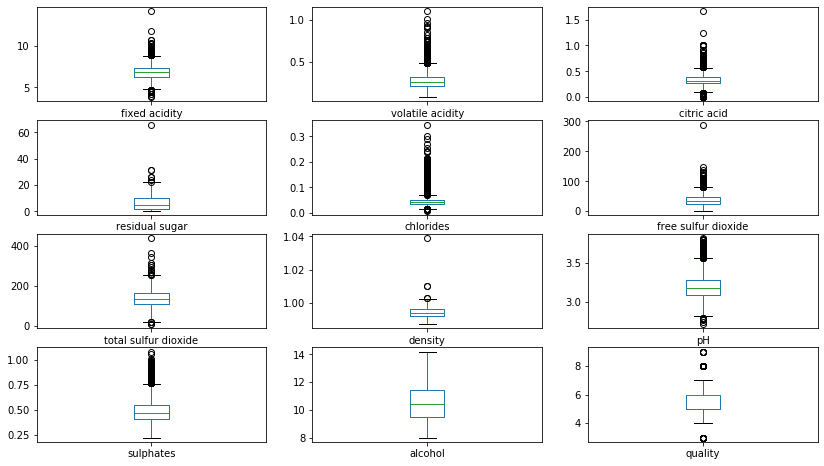

In [20]:
figsize = (14,8)
dataset_white.plot(kind='box', subplots=True, 
                   layout = (4,3), sharey=False, sharex=False, figsize=figsize);

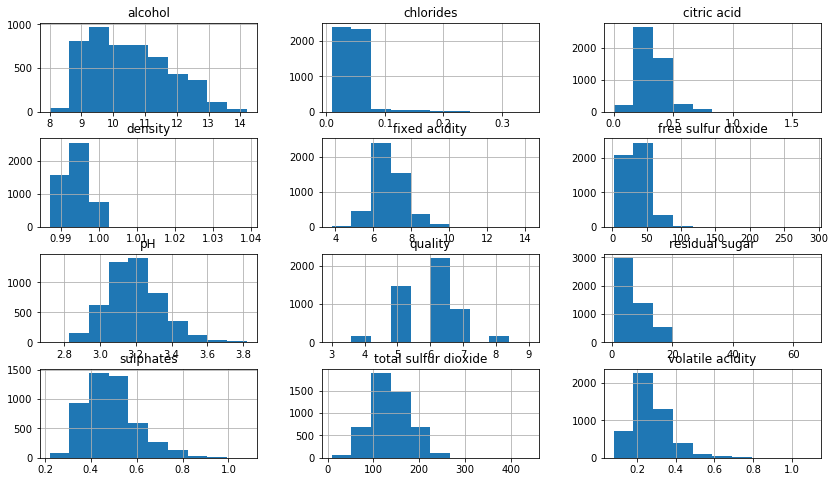

In [22]:
dataset_white.hist(figsize=figsize);

In [23]:
# correlation
corr = dataset_white.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2) 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1,-0.023,0.29,0.089,0.023,-0.049,0.091,0.27,-0.43,-0.017,-0.12,-0.11
volatile acidity,-0.023,1,-0.15,0.064,0.071,-0.097,0.089,0.027,-0.032,-0.036,0.068,-0.19
citric acid,0.29,-0.15,1,0.094,0.11,0.094,0.12,0.15,-0.16,0.062,-0.076,-0.0092
residual sugar,0.089,0.064,0.094,1,0.089,0.3,0.4,0.84,-0.19,-0.027,-0.45,-0.098
chlorides,0.023,0.071,0.11,0.089,1,0.1,0.2,0.26,-0.09,0.017,-0.36,-0.21
free sulfur dioxide,-0.049,-0.097,0.094,0.3,0.1,1,0.62,0.29,-0.00062,0.059,-0.25,0.0082
total sulfur dioxide,0.091,0.089,0.12,0.4,0.2,0.62,1,0.53,0.0023,0.13,-0.45,-0.17
density,0.27,0.027,0.15,0.84,0.26,0.29,0.53,1,-0.094,0.074,-0.78,-0.31
pH,-0.43,-0.032,-0.16,-0.19,-0.09,-0.00062,0.0023,-0.094,1,0.16,0.12,0.099
sulphates,-0.017,-0.036,0.062,-0.027,0.017,0.059,0.13,0.074,0.16,1,-0.017,0.054


In [25]:
# correlation per feature pairs
# top 10. 
melt_corr = dataset_white.corr().assign(cols = dataset_red.columns).melt(id_vars='cols', value_name = 'corr')
melt_corr.loc[melt_corr['corr'] != 1].assign(corr_abs = np.abs(melt_corr['corr'])).drop_duplicates('corr').nlargest(10, 'corr_abs').drop('corr_abs', axis =1)

,cols,variable,corr
43,density,residual sugar,0.838966
94,alcohol,density,-0.780138
66,total sulfur dioxide,free sulfur dioxide,0.615501
79,density,total sulfur dioxide,0.529881
46,alcohol,residual sugar,-0.450631
82,alcohol,total sulfur dioxide,-0.448892
131,quality,alcohol,0.435575
8,pH,fixed acidity,-0.425858
42,total sulfur dioxide,residual sugar,0.401439
58,alcohol,chlorides,-0.360189


## Evaluate Some Algorithms
Now it is time to create some models of the data and estimate their accuracy on unseen data.
Here is what we are going to cover in this step:
1. Separate out a validation dataset.
2. Setup the test harness to use 10-fold cross-validation.
3. Build 5 different models to predict species from flower measurements
4. Select the best model.

In [14]:
array = dataset_white.copy()
X = array.iloc[:, 0:11]
y= array.iloc[:,11]
hold_out_size = 0.2
seed = 49
X_train, X_hold_out, y_train, y_hold_out = train_test_split(X, y, test_size=hold_out_size, random_state=seed)

In [66]:
# Spot-check algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# evaluate each model in turn
num_folds = 10
scoring = 'accuracy' # aware of issues for imbalanced classes but using it for now as benchmark
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(estimator=model, X= X_train,y= y_train,cv = kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = f"{name} {cv_results.mean()} +/- ({cv_results.std()})"
    print(msg)

LR 0.5331743566992014 +/- (0.014858973311193154)
LDA 0.535981784017955 +/- (0.023383410161953472)
KNN 0.47344916227360506 +/- (0.011371985840566135)
CART 0.5929139046923118 +/- (0.02642603059958586)
NB 0.44793243384310244 +/- (0.027964309464977407)


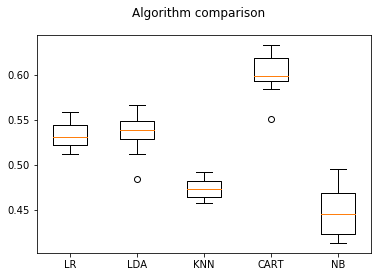

In [16]:
# compare performance
# CART is ahead
fig1 = pyplot.figure()
fig1.suptitle('Algorithm comparison')
ax = fig1.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [17]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LogisticRegression(solver='lbfgs', multi_class='ovr'))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA',
LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB',
GaussianNB())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.542363 (0.014327)
ScaledLDA: 0.535982 (0.023383)
ScaledKNN: 0.550550 (0.019965)
ScaledCART: 0.600815 (0.021862)
ScaledNB: 0.444360 (0.030528)


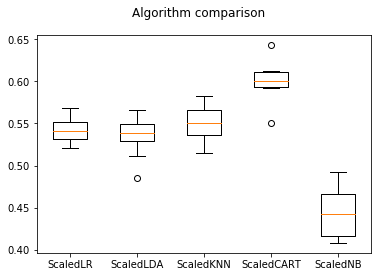

In [18]:
# compare performance
# some impromevment on distance learning algorithms as KNN but CART still overperforming
fig1 = pyplot.figure()
fig1.suptitle('Algorithm comparison')
ax = fig1.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### Dataset resampling

Due to quality class imbalance I will oversample with replacement the quality samples equal to 3, 4, 8 and 9.

- TBC - look into https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/


In [60]:
print(Counter(y))

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})


In [75]:
oversample = imblearn.over_sampling.SMOTE(k_neighbors=3)

In [76]:
X_balanced, y_balanced = oversample.fit_resample(X, y)

In [77]:
print(Counter(y_balanced))

Counter({6: 2198, 5: 2198, 7: 2198, 8: 2198, 4: 2198, 3: 2198, 9: 2198})


In [92]:
steps  = [('over', oversample), ('model', DecisionTreeClassifier())]
pipeline = imblearn.pipeline.Pipeline(steps=steps)
# evaluate the pipeline
scoring = 'accuracy'
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state=seed)
scores = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)
print(np.mean(scores))

0.5497188874547971


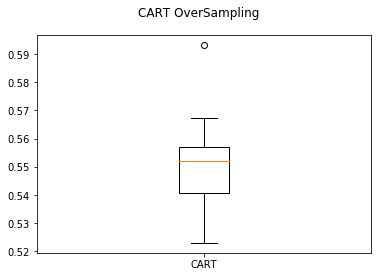

In [96]:
fig1 = pyplot.figure()
fig1.suptitle('CART OverSampling')
ax = fig1.add_subplot(111)
pyplot.boxplot(scores)
ax.set_xticklabels(['CART'])
pyplot.show()

#### Summary of results

- too low number of samples for high and lowest quality wines. Problems here with SMOTE sample generation
- Likely lowest and highest quality wines are more suitable for an anomaly detection/ outlier detection algorithm rather then a class problem
- retry problem as classification but define both classes 0 and 1 based on range of wines qualities